In [1]:
#%pip install langchain
#%pip install langchain-community
#%pip install langchain-groq
#%pip install sentence-transformers
#%pip install -U langchain-community faiss-cpu langchain-openai tiktoken
#%%capture --no-stderr
#%pip install -U langgraph langsmith
#%pip install pandas
#%pip install numpy

In [2]:
import pandas as pd
import numpy as np
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
import os 
import json
from langchain_core.runnables import RunnablePassthrough
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter


#define groq key 
groq_key = os.environ['groqkey']

llama_70 = 'llama3-70b-8192'
llama_31 = 'llama-3.1-70b-versatile'
mixtral = "mixtral-8x7b-32768"
gemma_2 = 'gemma2-9b-it'
llama_tool_70 = 'llama3-groq-70b-8192-tool-use-preview'

gemma = ChatGroq(
    temperature=0,
    model=gemma_2,
    api_key=groq_key 
)

mixtral = ChatGroq(
    temperature=0,
    model=mixtral,
    api_key=groq_key 
)

llama3 = ChatGroq(
    temperature=0,
    model=llama_70,
    api_key=groq_key 
)

llama_tool = ChatGroq(
    temperature=0,
    model=llama_70,
    api_key=groq_key 
)

llama_3_1 = ChatGroq(
    temperature=0,
    model=llama_31,
    api_key=groq_key 
)

llm = llama_tool


embeddings = HuggingFaceEmbeddings(model_name="NeuML/pubmedbert-base-embeddings")
text_splitter = RecursiveCharacterTextSplitter()

C:\Users\micha\AppData\Local\Temp\ipykernel_10200\529645324.py:57: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="NeuML/pubmedbert-base-embeddings")
f:\LangGraph\.venv\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [3]:
base_path = "F:/LangChain/data/"
encounterKey = 'DAABF28BCE02C7'


encounters = pd.read_csv(base_path + 'encounters.txt', sep="|")
hospitalAcquiredDx = pd.read_csv(base_path + 'hospitalAcquiredDx.txt', sep="|")
presentOnAdmitDx = pd.read_csv(base_path + 'presentOnAdmitDx.txt', sep="|")
noteText = pd.read_csv(base_path + 'noteText.csv')


hospitalAcquiredDx = hospitalAcquiredDx[hospitalAcquiredDx['EncounterKey'] == encounterKey]
noteText = noteText[noteText['EncounterKey'] == encounterKey]
presentOnAdmitDx = presentOnAdmitDx[presentOnAdmitDx['EncounterKey'] == encounterKey]
encounters = encounters[encounters['EncounterKey'] == encounterKey]

noteText['Source'] = 'Note'
hospitalAcquiredDx['Source'] = 'Hospital Acquired Dx'
presentOnAdmitDx['Source'] = 'Present on Admit Dx'

In [4]:
noteText.head()

,deid_note_key,EncounterKey,NoteDate,DepartmentSpecialty,ProviderSpecialty,ProviderType,NoteText,Source
516,D03C8F1E49F30B,DAABF28BCE02C7,2023-09-27,Inpatient Nursing,NaN,Registered Nurse,Problem: Discharge Planning - Adult Goal: K...,Note
4126,D21684E3C82621,DAABF28BCE02C7,2023-09-26,Inpatient Nursing,Hematology and Oncology,Physician,SPECIALTY E-CONSULT Consult requested by D...,Note
6029,D31203AFE0292B,DAABF28BCE02C7,2023-09-26,Inpatient Nursing,Hospital Medicine,Physician,HOSPITAL MEDICINE ED TRIAGE ATTENDING ***** **...,Note
6213,D32A5066A2ECE5,DAABF28BCE02C7,2023-09-27,Inpatient Nursing,Emergency Medicine,Registered Nurse,Patient's daughter LV for ED DCC regarding que...,Note
9335,D4BA2FD060C241,DAABF28BCE02C7,2023-09-27,Inpatient Nursing,UCSF,Resident,UCSF MEDICAL CENTER - ***** Patient Name: ...,Note


In [5]:
hospitalAcquiredDx = hospitalAcquiredDx.rename(columns={"DxName": "NoteText"})
presentOnAdmitDx = presentOnAdmitDx.rename(columns={"DxName": "NoteText"})

#combine all dataframes into one
combined_df = pd.concat([noteText, hospitalAcquiredDx, presentOnAdmitDx])

In [6]:
from langchain_community.document_loaders import DataFrameLoader
loader = DataFrameLoader(
 data_frame = combined_df,
 page_content_column = "NoteText",
 engine="pandas",
)

documents = loader.load_and_split()

In [7]:
documents[19]

Document(metadata={'deid_note_key': 'DF9AA4E9F966A2', 'EncounterKey': 'DAABF28BCE02C7', 'NoteDate': '2023-09-26', 'DepartmentSpecialty': 'Inpatient Nursing', 'ProviderSpecialty': 'UCSF', 'ProviderType': 'Resident', 'Source': 'Note'}, page_content='Oncology Plan of Care Note     Mr ***** is a ***** yo man with RA and polymyositis who has a new diagnosis of likely metastatic pancreatic cancer. Oncology is consulted for further workup and care coordination.     Briefly the patient presented to ***** Memorial on September 24 with several months of progressive RUQ pain and weight loss (30lbs over 4 months). CT A/P showed pancreas mass with multiple liver lesions. Biopsy of liver lesion was preformed September 25 and the patient was discharged with plan for outpatient follow up. He wished to transfer his care to UCSF so he presented to the ED here whereupon he was admitted to medicine. CT C/A/P on September 26 redemonstrated pancreas body mass with enlarged mesenteric LN para-aortic soft tis

In [8]:
#print(len(documents))
documents[20]

Document(metadata={'deid_note_key': nan, 'EncounterKey': 'DAABF28BCE02C7', 'NoteDate': nan, 'DepartmentSpecialty': nan, 'ProviderSpecialty': nan, 'ProviderType': nan, 'Source': 'Hospital Acquired Dx'}, page_content='*Unspecified')

In [9]:
vector_store = FAISS.from_documents(documents, embeddings)

retriever = vector_store.as_retriever(search_type="similarity")



In [10]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

dx_retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_diagnosis_info",
    "Search and return diagnosis information for evaluation of patient specific to the question that is asked",
)


ppi_retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_ppi_reason",
    "Search and return the reason that the patient is taking a specific medication",
)

tools = [dx_retriever_tool, ppi_retriever_tool]

In [11]:
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage, trim_messages



trimmer = trim_messages(
    max_tokens=100000,
    strategy="last",
    token_counter=llm,
    include_system=True,
)


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }


def create_team_supervisor(llm: ChatGroq, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | trimmer
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [20]:
import functools
import operator

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from typing_extensions import TypedDict
from typing import Annotated, List

# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str




dx_agent = create_react_agent(llama_3_1, tools=[dx_retriever_tool])
dx_node = functools.partial(agent_node, agent=dx_agent, name="Dx")

ppi_agent = create_react_agent(llama_3_1, tools=[ppi_retriever_tool])
ppi_node = functools.partial(agent_node, agent=ppi_agent, name="PPI")

supervisor_agent = create_team_supervisor(
    llama_tool,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Dx, PPI.  The Dx worker is able to see if a patient has a specific diagnosis.  The PPI worker is able to see the reason a patient is taking a specific medication." 
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished answering the questions,"
    " respond with FINISH.",
    ["Dx", "PPI"],
)

In [21]:
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Dx", dx_node)
research_graph.add_node("PPI", ppi_node)
research_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
research_graph.add_edge("Dx", "supervisor")
research_graph.add_edge("PPI", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Dx": "Dx", "PPI": "PPI", "FINISH": END},
)


research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | chain

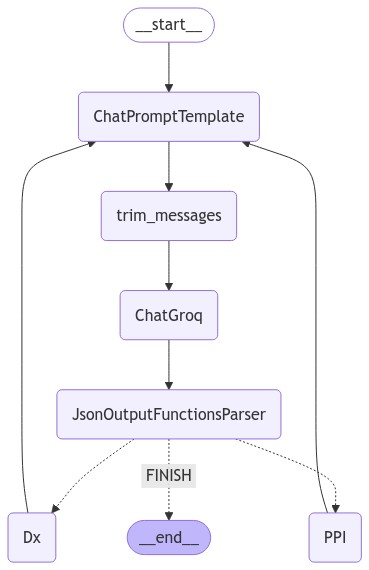

In [22]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

In [23]:
for s in research_chain.stream(
    "Answer two questions: 1. Does the patient have barrett's esophagus.  2. What is the reason that the patient is taking a proton pump inhibitor (PPI)?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Dx'}}
---
{'Dx': {'messages': [HumanMessage(content="The patient does not have Barrett's esophagus. The reason the patient is taking a proton pump inhibitor (PPI) is for gastrointestinal prophylaxis (GI ppx) while taking other medications, specifically Advil, to protect the stomach lining.", additional_kwargs={}, response_metadata={}, name='Dx')]}}
---
{'supervisor': {'next': 'Dx'}}
---


APIStatusError: Error code: 413 - {'error': {'message': 'Request too large for model `llama3-70b-8192` in organization `org_01hys9s2mffcj9xqn0vnwc5dg5` on tokens per minute (TPM): Limit 6000, Used -1919, Requested 7919, please reduce your message size and try again. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}